In [15]:
!git clone https://github.com/milarobotlearningcourse/micro_vlm.git
%cd mini_crossformer
# !pip3 install -r requirements.txt

Cloning into 'micro_vlm'...
Username for 'https://github.com': ^C
[Errno 2] No such file or directory: 'mini_crossformer'
/home/gberseth/playground/mini-grp/micro-vlm


Outline:

1. Data processing and parsing
    1. Processing the image data to be a single size
    2. Processing and tokenizing text data.
1. How to create a VIT from the GPT code
    1. Change to an encoder
    2. Tokenizing the image patches
1. Making A Multi-Modal Model for the VLM
    1. Adding back the text input
    2. Changing the masking for the text tokens to be causal
    3. Padding the data to increase context size and learning speed
    4. Batching for the learning data across sub-strings
1. Training the model
    1. Number of layers and optimization
    2. Initilization
1. Using T5 to encode text
1. Generating output from the model

  

Question: Where are the kids riding?
multiple_choice_answer: carnival ride


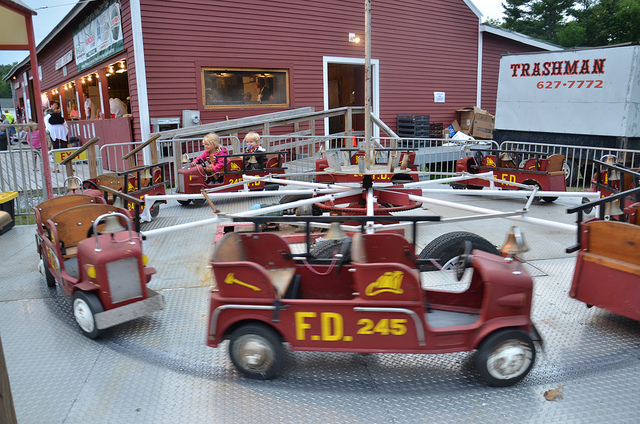

In [44]:
from PIL import Image
from IPython import display
import numpy as np
import cv2

def as_gif(images, path='temp.png'):
  # Render the images as the gif:
  images = [Image.fromarray(image) for image in images]
  images[0].save(path, save_all=True, append_images=images[1:], duration=1000, loop=0)
  gif_bytes = open(path,'rb').read()
  return gif_bytes

import datasets, cv2
dataset = datasets.load_dataset("merve/vqav2-small")
dataset = dataset['validation']

# extract image & language instruction
image = dataset[0]["image"]
question = dataset[0]["question"]
mca = dataset[0]["multiple_choice_answer"]

# visualize episode
print(f'Question: {question}')
print(f'multiple_choice_answer: {mca}')
# display.Image(Image.fromarray(image))
### Display the image in the notebook
cv2.imwrite('temp.png', cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR))
display.display(display.Image('temp.png'))

In [46]:
## Let's load the config and prepare the dataset for some training

from box import Box
import os, torch

# Define the path to your config file
config_path = os.path.join("conf", "micro-vlm-64pix.yaml")
cfg = Box.from_yaml(filename=config_path)
cfg.trim = 100  # Trim dataset to this size for faster testing

dataset = datasets.load_dataset(cfg.dataset.dataset_name)

# cbuffer = CircularBuffer(cfg.dataset.buffer_size, cfg)
dataset = dataset['validation']

chars = sorted(list(set([item for row in dataset["question"] for item in row] + [item for row in dataset["multiple_choice_answer"] for item in row]))) ## Flatten to a long string
cfg.vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode_txt = lambda s: [stoi[c] for c in s] # text encoder to tokens: 
decode_txy = lambda l: ''.join([itos[i] for i in l]) # token decoder to text: 
print("vocab_size:", cfg.vocab_size)
print("example text encode:", encode_txt(dataset["question"][0])) 

# dataset = dataset.add_column("text2", np.array(text))

# dataset.set_format(type="torch", columns=["image", "question", "multiple_choice_answer", "text2"], device=device)

if cfg.dataset.save_initial_dataset:
    dataset__ = {"image": [], "question": [], "multiple_choice_answer": []}
    for i in range(min(cfg.trim, dataset.num_rows)):
        item = dataset[i]
        if item["image"].mode == "RGB":
            dataset__["image"].append(cv2.resize(np.array(item["image"], dtype=np.uint8), (cfg.image_shape[0], cfg.image_shape[1])))
            dataset__["question"].append(item["question"])
            dataset__["multiple_choice_answer"].append(item["multiple_choice_answer"])
    # del dataset
    ## Convert lists to torch tensors
    dataset__["image"] = np.array(dataset__["image"], dtype=np.uint8)
    dataset__["question"] = np.array(dataset__["question"])
    dataset__["multiple_choice_answer"] = np.array(dataset__["multiple_choice_answer"])
    from datasets import Image, Dataset
    dataset = Dataset.from_dict(dataset__)

    new_features = dataset.features.copy()
    new_features["image"] = Image()
    dataset.cast(new_features)
    print('Features:', dataset.features)
    # dataset.save_to_disk("datasets/" + cfg.dataset.to_dataset_name_new + ".hf")
    # dataset.push_to_hub(cfg.dataset.to_dataset_name_new)

images = []
text = []
lengths = []
padding_ = " " * (int(cfg.phrase_length)+1) ## making up 64 for now.
for i in range(min(len(dataset), cfg.trim)):
    if dataset[i]["image"].mode != "RGB":
        continue
    text_t = dataset[i]["question"]+dataset[i]["multiple_choice_answer"]
    lengths.append(min(max(cfg.max_block_size+2, len(text_t)), cfg.phrase_length+1)) ## plus two for padding and target token
    ## Pad the text to at least 64
    text_ = text_t[0:65] + padding_[len(text_t):cfg.phrase_length + 1]
    text.append(np.array(encode_txt(text_[:cfg.phrase_length + 1])))
    assert len(text[-1]) == cfg.phrase_length + 1
    images.append(cv2.resize(np.array(dataset[i]["image"], dtype=np.uint8), (cfg.image_shape[0], cfg.image_shape[1])))
    assert images[-1].shape == (cfg.image_shape[0], cfg.image_shape[1], cfg.image_shape[2])
dataset_ = {"image": torch.tensor(np.array(images, dtype=np.uint8), dtype=torch.uint8, device=cfg.device),
            "text2": torch.tensor(np.array(text, dtype=np.int32), dtype=torch.long, device=cfg.device),
            "text_lengths": np.array(lengths, dtype=np.int32)
            }

print ('Dataset prepared with {} samples.'.format(len(dataset_["image"])))
dataset_

vocab_size: 79
example text encode: [48, 60, 57, 70, 57, 0, 53, 70, 57, 0, 72, 60, 57, 0, 63, 61, 56, 71, 0, 70, 61, 56, 61, 66, 59, 25]
Dataset prepared with 100 samples.


{'image': tensor([[[[ 56,  20,  21],
           [ 66,  65,  75],
           [175, 208, 230],
           ...,
           [ 40,  59,  43],
           [ 63,  96,  44],
           [ 70,  99,  48]],
 
          [[156, 146, 110],
           [ 77,  37,  38],
           [ 71,  28,  32],
           ...,
           [ 40,  59,  36],
           [ 48,  74,  38],
           [ 34,  60,  29]],
 
          [[156, 144, 109],
           [150, 137, 102],
           [ 88,  52,  43],
           ...,
           [ 42,  67,  44],
           [ 26,  46,  23],
           [ 22,  38,  20]],
 
          ...,
 
          [[ 87,  82,  77],
           [151, 160, 168],
           [172, 191, 202],
           ...,
           [161, 179, 194],
           [164, 184, 198],
           [155, 173, 189]],
 
          [[ 83,  74,  66],
           [107, 101,  97],
           [161, 177, 186],
           ...,
           [167, 183, 198],
           [160, 178, 192],
           [152, 169, 185]],
 
          [[ 84,  76,  68],
           

# How to create a VIT from the Transformer (NanoGPT) code
We have some familiarity with a visual question answering dataset. It contains multiple types of inputs, text and images and outputs. We need to make a model that will process in the input data and output the correct values depending on the input observation (img) and text. I am going to extend some of Karpathi's gpt-nano code to keep as much of the model and details visable as we learn about this process. We will start with creating a vision transformer from the code.

In [1]:
## Need to adjust the masking.
# We can have fully connected attention (encoder) or partially attended transformers.
# Need to discuss this because we are going to modify this a couple times for our GRP.
# For images we want an encoder
import torch
import torch.nn as nn
from torch.nn import functional as F
# Self-attention
torch.manual_seed(1338)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C)

# One head self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False) ## Here is what I am interested in
query = nn.Linear(C, head_size, bias=False) ## This is what I have
value = nn.Linear(C, head_size, bias=False) ## Here is what I will communicate if you find me useful
k = key(x)   # (B, T, 32)
q = query(x) # (B, T, 32)
wei =  q @ k.transpose(-2, -1) # (B, T, 32) @ (B, 32, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
# wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf')) ## Remove this to make an encoder
wei = F.softmax(wei, dim=-1) ## This normalizes the values for a good distribution (sum to 1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape

torch.Size([4, 8, 16])

In [2]:
## Look at the attention for one head
wei[0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3950, 0.6050, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2771, 0.6117, 0.1113, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.8070, 0.0474, 0.1162, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0810, 0.4221, 0.1671, 0.1875, 0.1423, 0.0000, 0.0000, 0.0000],
        [0.5163, 0.0798, 0.1404, 0.1087, 0.1345, 0.0202, 0.0000, 0.0000],
        [0.0239, 0.0423, 0.1803, 0.0465, 0.0741, 0.4494, 0.1834, 0.0000],
        [0.3700, 0.0179, 0.0431, 0.2021, 0.2487, 0.0472, 0.0671, 0.0038]],
       grad_fn=<SelectBackward0>)

## Transformer Code

In [40]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## This is an encoder head with full attention
class Head(nn.Module):

    def __init__(self, head_size, n_embd, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        ## Why can we remove the buffer below?
        # self.register_buffer('tril', torch.tril(torch.ones(max_max_max_block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        # wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T) ## Remove masking
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ Create multiple heads for self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication then computation """

    def __init__(self, n_embd, n_head, dropout):
        ## n_embd: embedding dimension, n_head: the number of heads we want
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

## Tokenizing Images
Transformers process tokens. The nano GPT model was designed to treat each letter as an individual token and train a model to continue outputing more tokens given a recent context of tokens. However most LLMs break up words into phonemes and pieces of words in a particular way to both represent the possible components of words well and keep the number of possible tokens within a reasonable number. This asks the question, how to tokenize an image? We litterally chop the image into $m$ equally sized __patches__.



In [5]:
def get_patches_fast(images, cfg):
    """ images: (batch_size, height, width, channels)
        returns: (batch_size, n_patches, patch_size*patch_size*channels)
        
        This code takes an image tensor and splits it into patches using einops rearrange for efficiency.
        Here is a example of the patching process in text form:
           


        """
    from einops import rearrange
    batch_size, height, width, channels = images.shape
    patch_size = cfg.patch_size ## n_patches = 8

    patches = rearrange(images[:,:,:,:3], 'b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size)
    if channels > 3:
        ## History stacking in the channel dimension for observations only, not goal images.
        patches = rearrange(images, 'b (h p1) (w p2) (c hs) -> b (h w hs) (p1 p2 c)', p1 = patch_size, p2 = patch_size, hs=cfg.policy.obs_stacking) ## Stack the history in the channel dimension
    return patches

Testing get_patches_fast...
Image shape: <built-in method size of Tensor object at 0x70582c5bb150>


/tmp/ipykernel_168271/779439954.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = get_patches_fast(torch.tensor(dataset_["image"][:5]), cfg)


Patch shape: (192,)


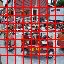

In [10]:
print('Testing get_patches_fast...')
## print out image shape
print("Image shape:", dataset_["image"][0].size)
out = get_patches_fast(torch.tensor(dataset_["image"][:5]), cfg)
out[0].shape
# out[0]
## display the first patch
from IPython import display
patch = out[0][0].cpu().numpy().astype(np.uint8)
print("Patch shape:", patch.shape)
image = patch.reshape(8,8,3)
cv2.imwrite('temp_patch.png', cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
display.display(display.Image('temp_patch.png'))
### Display the patches put back together with a line between the patches
from einops import rearrange
reconstructed = rearrange(out[0], ' (h w) (p1 p2 c) -> (h p1) (w p2) c', h=8, w=8, p1=8, p2=8, c=3).cpu().numpy().astype(np.uint8)
# Add lines between patches
line_color = [255, 0, 0]  # Red lines
for i in range(1, 8):
    reconstructed[i*8-1:i*8, :, :] = line_color
    reconstructed[:, i*8-1:i*8, :] = line_color
cv2.imwrite('reconstructed_with_lines.png', cv2.cvtColor(reconstructed, cv2.COLOR_RGB2BGR))
display.display(display.Image('reconstructed_with_lines.png'))  

### Compute the Position Embeddings

These embeddings help the transformer keep track of where items are located in the image. Location can be more important for certain types of tasks.

https://arxiv.org/abs/2010.11929

In [11]:
def calc_positional_embeddings(sequence_length, d):
    out = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            out[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return out

In [12]:
## Helper routines to simplify training.

def get_batch(dataset, cfg):
    from PIL import Image
    import cv2
    ## Get a batch of data from the hugging face dataset dataset
    ix = np.random.randint(len(dataset["image"]), size=(cfg.batch_size))
    X_img = dataset['image'][ix]    
    
    ## Need to get a random section of each row in the txt data that is randomly cropped to max_block_size + 1
    txt = dataset['text2'][ix]  ## plus one for the target token
    ## The target token is the next token after the block
    Y = txt[:, -1] ## Target token is the last token for now
    X_text = txt[:, 0:cfg.max_block_size] ## Just ignor this for now
        
    ## Convert images to float32
    X_img = X_img.float() / 255.0
    return X_text, X_img, Y


@torch.no_grad()
def estimate_loss(model, dataset, cfg):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X_text, X_img, Y = get_batch(dataset, cfg)
            logits, loss = model(X_img, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [41]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader

import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm, trange
import cv2


class VIT(nn.Module):
  def __init__(self, dataset, cfg, mlp_ratio=4):
    super(VIT, self).__init__()
    self._dataset = dataset
    self._cfg = cfg
    # self.patch_size = (cfg.image_shape[0] / cfg.n_patches, cfg.image_shape[1] / cfg.n_patches)

    #Positional embedding
    self.register_buffer('positional_embeddings', 
                         calc_positional_embeddings((int(cfg.image_shape[0] / cfg.patch_size) ** 2) + 1, 
                                                    cfg.n_embd), persistent=False)

    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(cfg.image_shape[2] * (cfg.patch_size * cfg.patch_size))

    self.lin_map = nn.Linear(self.input_d, cfg.n_embd, bias=False)

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(cfg.n_embd, cfg.n_head, dropout=self._cfg.dropout) for _ in range(cfg.n_blocks)])

    # 5) Classification MLP
    self.mlp = nn.Sequential(
        nn.Linear(cfg.n_embd, cfg.action_bins),
        nn.Softmax(dim=-1)
    )

  def forward(self, images, targets=None):
    # Dividing images into patches
    n, c, h, w = images.shape
    patches = get_patches_fast(images, self._cfg)

    # Running linear layer tokenization
    # Map the vector corresponding to each patch to the hidden size dimension
    out = self.lin_map(patches)

    # Adding classification token to the tokens
    out = torch.cat((self.class_tokens.expand(n, 1, -1), out), dim=1)

    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)

    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only
    out = out[:, 0]
    logits = self.mlp(out)

    if targets is None:
        loss = None
    else:
        # B,T,C = 4,8,2 # batch, time, channels
        B, C = logits.shape
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    return (logits, loss)


In [42]:

def my_main():

    
    model = VIT(dataset_, cfg)
    m = model.to(cfg.device)
    # print the number of parameters in the model
    print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))

    for iter in range(cfg.max_iters):

        # every once in a while evaluate the loss on train and val sets
        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model, dataset_, cfg)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # sample a batch of data
        xt, xb, yb = get_batch(dataset_, cfg)

        # evaluate the loss
        logits, loss = model(xb, yb)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    return losses['val']

if __name__ == "__main__":
    import os
    results = my_main()
    print("results:", results)

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# Vision Language Model (VLMs)
These models take images and text as inputs.
We will train this model over the VQA dataset
(image, question) -> VLM -> answer
Let's start with adding text conditioning.

## Adding text questions

In [34]:
## First we need to update the data we are collecting to include text questions

from box import Box
import os, torch

# Define the path to your config file
config_path = os.path.join("conf", "micro-vlm-64pix.yaml")
cfg = Box.from_yaml(filename=config_path)
cfg.trim = 100  # Trim dataset to this size for faster testing

dataset = datasets.load_dataset(cfg.dataset.dataset_name)

# cbuffer = CircularBuffer(cfg.dataset.buffer_size, cfg)
dataset = dataset['validation']

chars = sorted(list(set([item for row in dataset["question"] for item in row] + [item for row in dataset["multiple_choice_answer"] for item in row]))) ## Flatten to a long string
cfg.vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode_txt = lambda s: [stoi[c] for c in s] # text encoder to tokens: 
decode_txy = lambda l: ''.join([itos[i] for i in l]) # token decoder to text: 
print("vocab_size:", cfg.vocab_size)
print("example text encode:", encode_txt(dataset["question"][0])) 

# dataset = dataset.add_column("text2", np.array(text))

# dataset.set_format(type="torch", columns=["image", "question", "multiple_choice_answer", "text2"], device=device)

if cfg.dataset.save_initial_dataset:
    dataset__ = {"image": [], "question": [], "multiple_choice_answer": []}
    for i in range(min(cfg.trim, dataset.num_rows)):
        item = dataset[i]
        if item["image"].mode == "RGB":
            dataset__["image"].append(cv2.resize(np.array(item["image"], dtype=np.uint8), (cfg.image_shape[0], cfg.image_shape[1])))
            dataset__["question"].append(item["question"])
            dataset__["multiple_choice_answer"].append(item["multiple_choice_answer"])
    # del dataset
    ## Convert lists to torch tensors
    dataset__["image"] = np.array(dataset__["image"], dtype=np.uint8)
    dataset__["question"] = np.array(dataset__["question"])
    dataset__["multiple_choice_answer"] = np.array(dataset__["multiple_choice_answer"])
    from datasets import Image, Dataset
    dataset = Dataset.from_dict(dataset__)

    new_features = dataset.features.copy()
    new_features["image"] = Image()
    dataset.cast(new_features)
    print('Features:', dataset.features)
    # dataset.save_to_disk("datasets/" + cfg.dataset.to_dataset_name_new + ".hf")
    # dataset.push_to_hub(cfg.dataset.to_dataset_name_new)

images = []
text = []
lengths = []
padding_ = " " * (int(cfg.phrase_length)+1) ## making up 64 for now.
for i in range(min(len(dataset), cfg.trim)):
    if dataset[i]["image"].mode != "RGB":
        continue
    text_t = dataset[i]["question"]+dataset[i]["multiple_choice_answer"]
    lengths.append(min(max(cfg.max_block_size+2, len(text_t)), cfg.phrase_length+1)) ## plus two for padding and target token
    ## Pad the text to at least 64
    text_ = text_t[0:65] + padding_[len(text_t):cfg.phrase_length + 1]
    text.append(np.array(encode_txt(text_[:cfg.phrase_length + 1])))
    assert len(text[-1]) == cfg.phrase_length + 1
    images.append(cv2.resize(np.array(dataset[i]["image"], dtype=np.uint8), (cfg.image_shape[0], cfg.image_shape[1])))
    assert images[-1].shape == (cfg.image_shape[0], cfg.image_shape[1], cfg.image_shape[2])
dataset_ = {"image": torch.tensor(np.array(images, dtype=np.uint8), dtype=torch.uint8, device=cfg.device),
            "text2": torch.tensor(np.array(text, dtype=np.int32), dtype=torch.long, device=cfg.device),
            "text_lengths": np.array(lengths, dtype=np.int32)
            }

print ('Dataset prepared with {} samples.'.format(len(dataset_["image"])))
dataset_

vocab_size: 79
example text encode: [48, 60, 57, 70, 57, 0, 53, 70, 57, 0, 72, 60, 57, 0, 63, 61, 56, 71, 0, 70, 61, 56, 61, 66, 59, 25]
Dataset prepared with 100 samples.


{'image': tensor([[[[ 56,  20,  21],
           [ 66,  65,  75],
           [175, 208, 230],
           ...,
           [ 40,  59,  43],
           [ 63,  96,  44],
           [ 70,  99,  48]],
 
          [[156, 146, 110],
           [ 77,  37,  38],
           [ 71,  28,  32],
           ...,
           [ 40,  59,  36],
           [ 48,  74,  38],
           [ 34,  60,  29]],
 
          [[156, 144, 109],
           [150, 137, 102],
           [ 88,  52,  43],
           ...,
           [ 42,  67,  44],
           [ 26,  46,  23],
           [ 22,  38,  20]],
 
          ...,
 
          [[ 87,  82,  77],
           [151, 160, 168],
           [172, 191, 202],
           ...,
           [161, 179, 194],
           [164, 184, 198],
           [155, 173, 189]],
 
          [[ 83,  74,  66],
           [107, 101,  97],
           [161, 177, 186],
           ...,
           [167, 183, 198],
           [160, 178, 192],
           [152, 169, 185]],
 
          [[ 84,  76,  68],
           

In [25]:
## Need to update some to the transformer code for VLM to include the 
## This is an encoder head (full attention)
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, dropout, cfg):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        ## Need to create the context length and masking size
        context_length = cfg.max_block_size + (int(cfg.image_shape[0] / cfg.patch_size) ** 2) + 1
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        # [TODO]
        """
        [DEFAULT]
        # TODO: 
        ## Provide the block masking
        pass
        [/DEFAULT]
        """
        # if mask == None:
        #     mask = torch.ones((T, ), device=self.device) ## (1, T)
        # [/TODO]
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        ### Block masked attention
        # wei = wei.masked_fill(mask == 0, float('-inf')) # (B, T, T)
        wei[:,64:] = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))[:,64:] # (B, T, T) The attention after the first image tokens should be causal (only attend to previous tokens)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout, cfg):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout, cfg=cfg) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        with torch.profiler.record_function("Self-Attention"):
            out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
            out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), ## This is where the information may be stored.
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x,)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout, cfg):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout, cfg=cfg)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x = x + self.sa(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return x

In [26]:
class VLM(nn.Module):
  def __init__(self, cfg, mlp_ratio=4):
    super(VLM, self).__init__()
    # self._dataset = dataset
    self._cfg = cfg
    # [TODO]
    """
    [DEFAULT]
    # TODO: 
    ## Provide the logic for the GRP network

    # 4) Transformer encoder blocks

    # 5) Classification MLPk
    
    [/DEFAULT]
    """
    # self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)
    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 +        
                      int(cfg.image_shape[0] / cfg.patch_size) ** 2 +
                      self._cfg.max_block_size, ## image
                      cfg.n_embd), 
                      persistent=False)

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * cfg.patch_size * cfg.patch_size)

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 
    self.lin_map_pose = nn.Linear(7, self._cfg.n_embd, bias=True) 
    self.lin_map_pose_m1 = nn.Linear(30, self._cfg.n_embd, bias=True) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout, cfg=cfg) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),  # Output size is action_bins 
    )
    self.mlp_m1 = nn.Sequential(
        nn.Linear(self._cfg.n_embd, 12),  # Output size is action_bins
    )
    # [/TODO]

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, X_text, X_images, targets):
    # Dividing images into patches
    n, c, h, w = X_images.shape

    obs_patches = get_patches_fast(X_images, self._cfg) 
    if self._cfg.dataset.encode_with_t5:
        goals_e = X_text ## This is actually the embedding from the T5 model
        B, T, E = X_text.shape
    else:
        goals_e = self.token_embedding_table(X_text)
        B, E = X_text.shape
        T = self._cfg.max_block_size
    
    out_obs = self.lin_map(obs_patches) ## List of tensors, one for each stacked observation
    out = torch.cat((out_obs, goals_e, self.class_tokens.expand(n, 1, -1)), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only as the last 1 token(s)
    out = out[:, -1]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = logits.shape
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    return (logits, loss)
  
  def generate(self, idx, image, max_new_tokens, cfg):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -cfg.max_block_size:]
            # get the predictions
            logits, loss = self(idx_cond, image, None)
            # focus only on the last time step
            logits = logits # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
  

In [32]:
def get_batch(dataset, cfg):
    from PIL import Image
    import cv2
    ## Get a batch of data from the hugging face dataset dataset
    ix = np.random.randint(len(dataset["image"]), size=(cfg.batch_size))
    X_img = dataset['image'][ix]    
    
    ## Need to get a random section of each row in the txt data that is randomly cropped to max_block_size + 1
    r_ixd = np.random.randint(0, dataset['text_lengths'][ix] - (cfg.max_block_size + 1), size=(cfg.batch_size)) ## some text strings can be shorter than the block size
    txt = dataset['text2'][ix]  ## plus one for the target token
    ## Text models work best when auto-regressize, so we need to predict the next tokens in a sequence.
    ## But, different from the nano gpt example, which is one long text, here we have multiple text strings of different lengths.
    ## So we need to randomly crop a section of each text string for each batch element.
    txt = [txt[i][r_ixd[i]:r_ixd[i]+cfg.max_block_size+1] for i in range(len(txt))  ]  ## Grab random crops of text
    txt = torch.stack(txt, dim=0)
    ## The target token is the next token after the block
    Y = txt[:, -1]
    X_text = txt[:, 0:cfg.max_block_size]
        
    ## Convert images to float32
    X_img = X_img.float() / 255.0
    return X_text, X_img, Y


@torch.no_grad()
def estimate_loss(model, dataset, cfg, encode_txt):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X_text, X_img, Y = get_batch(dataset, cfg)
            logits, loss = model(X_text, X_img, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [ ]:
import os
from box import Box
def my_main():
    config_path = os.path.join("conf", "micro-vlm-64pix.yaml")
    cfg = Box.from_yaml(filename=config_path)
    cfg.trim = 100  # Trim dataset to this size for faster testing
    torch.manual_seed(cfg.r_seed)
    
    model = VLM(cfg)
    # model.to(device)
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
    ## Print the amount of memory used by the model
    # print("Memory used by the model:", torch.cuda.memory_allocated(device) / 1e6, "MB")
    ## Print the amount of memory used by the dataset cBuffer
    from pympler import asizeof
    # cBuffer.print_mem_footprint()


    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))
    import torch.optim.lr_scheduler as lr_scheduler
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=cfg.max_iters)

    for iter in range(cfg.max_iters):

        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model, dataset_, cfg, encode_txt)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, memory {torch.cuda.memory_allocated(device) / 1e6:.2f} MB")
            xq, xi, yb = get_batch(dataset_, cfg)
            print("Q: " + decode_txt(xq[0].tolist())) ## Print the question
            print("A: " + decode_txt(model.generate(xq[:1], xi[:1], max_new_tokens=cfg.max_block_size, cfg=cfg)[0].tolist())) ## Decode the responses learned so far

        if iter == cfg.max_iters - 1:
            path_ = "./microVLM.pth"
            torch.save(model, path_)
            print("Model saved to " + path_)

        # if iter % cfg.data_shuffel_interval == 0 and iter > 0:
        #     ## Update the dataset
        #     shared_queue.put('shuffle')

        xq, xi, yb = get_batch(dataset_, cfg)

        # evaluate the loss
        logits, loss = model(xq, xi, yb)
        loss.backward()

        if (iter + 1) % cfg.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)

    # shared_queue.put(None)
    # data_thread.join()

    return losses['val']

results = my_main()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
## This is an encoder head (full attention)
## We need to chage this to a block masked (causal) attention head
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, dropout, cfg):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        context_length = cfg.max_block_size + (int(cfg.image_shape[0] / cfg.patch_size) ** 2) + 1
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        # [TODO]
        """
        [DEFAULT]
        # TODO: 
        ## Provide the block masking
        pass
        [/DEFAULT]
        """
        # if mask == None:
        #     mask = torch.ones((T, ), device=self.device) ## (1, T)
        # [/TODO]
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        ### Block masked attention
        # wei = wei.masked_fill(mask == 0, float('-inf')) # (B, T, T)
        wei[:,64:] = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))[:,64:] # (B, T, T) The attention after the first image tokens should be causal (only attend to previous tokens)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

In [ ]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import numpy as np
import torch.profiler

def preprocess_data(cfg):
    import datasets, cv2
    dataset = datasets.load_dataset(cfg.dataset.dataset_name)

    # cbuffer = CircularBuffer(cfg.dataset.buffer_size, cfg)
    dataset = dataset['validation']

    chars = sorted(list(set([item for row in dataset["question"] for item in row] + [item for row in dataset["multiple_choice_answer"] for item in row]))) ## Flatten to a long string
    cfg.vocab_size = len(chars)
    # create a mapping from characters to integers
    stoi = { ch:i for i,ch in enumerate(chars) }
    itos = { i:ch for i,ch in enumerate(chars) }
    encode_txt = lambda s: [stoi[c] for c in s] # text encoder to tokens: 
    decode_txy = lambda l: ''.join([itos[i] for i in l]) # token decoder to text: 
    print("vocab_size:", cfg.vocab_size)
    print("example text encode:", encode_txt(dataset["question"][0])) 

    # dataset = dataset.add_column("text2", np.array(text))
    
    # dataset.set_format(type="torch", columns=["image", "question", "multiple_choice_answer", "text2"], device=device)

    if cfg.dataset.save_initial_dataset:
        dataset__ = {"image": [], "question": [], "multiple_choice_answer": []}
        for i in range(min(cfg.trim, dataset.num_rows)):
            item = dataset[i]
            if item["image"].mode == "RGB":
                dataset__["image"].append(cv2.resize(np.array(item["image"], dtype=np.uint8), (cfg.image_shape[0], cfg.image_shape[1])))
                dataset__["question"].append(item["question"])
                dataset__["multiple_choice_answer"].append(item["multiple_choice_answer"])
        # del dataset
        ## Convert lists to torch tensors
        dataset__["image"] = np.array(dataset__["image"], dtype=np.uint8)
        dataset__["question"] = np.array(dataset__["question"])
        dataset__["multiple_choice_answer"] = np.array(dataset__["multiple_choice_answer"])
        from datasets import Image, Dataset
        dataset = Dataset.from_dict(dataset__)

        new_features = dataset.features.copy()
        new_features["image"] = Image()
        dataset.cast(new_features)
        print('Features:', dataset.features)
        # dataset.save_to_disk("datasets/" + cfg.dataset.to_dataset_name_new + ".hf")
        # dataset.push_to_hub(cfg.dataset.to_dataset_name_new)

    images = []
    text = []
    lengths = []
    padding_ = " " * (int(cfg.phrase_length)+1) ## making up 64 for now.
    for i in range(min(len(dataset), cfg.trim)):
        if dataset[i]["image"].mode != "RGB":
            continue
        text_t = dataset[i]["question"]+dataset[i]["multiple_choice_answer"]
        lengths.append(min(max(cfg.max_block_size+2, len(text_t)), cfg.phrase_length+1)) ## plus two for padding and target token
        ## Pad the text to at least 64
        text_ = text_t[0:65] + padding_[len(text_t):cfg.phrase_length + 1]
        text.append(np.array(encode_txt(text_[:cfg.phrase_length + 1])))
        assert len(text[-1]) == cfg.phrase_length + 1
        images.append(cv2.resize(np.array(dataset[i]["image"], dtype=np.uint8), (cfg.image_shape[0], cfg.image_shape[1])))
        assert images[-1].shape == (cfg.image_shape[0], cfg.image_shape[1], cfg.image_shape[2])
    dataset_ = {"image": torch.tensor(np.array(images, dtype=np.uint8), dtype=torch.uint8, device=cfg.device),
                "text2": torch.tensor(np.array(text, dtype=np.int32), dtype=torch.long, device=cfg.device),
                "text_lengths": np.array(lengths, dtype=np.int32)
                }

    return dataset_, encode_txt, decode_txy

def get_batch(dataset, cfg):
    from PIL import Image
    import cv2
    ## Get a batch of data from the hugging face dataset dataset
    ix = np.random.randint(len(dataset["image"]), size=(cfg.batch_size))
    X_img = dataset['image'][ix]    
    
    ## Need to get a random section of each row in the txt data that is randomly cropped to max_block_size + 1
    r_ixd = np.random.randint(0, dataset['text_lengths'][ix] - (cfg.max_block_size + 1), size=(cfg.batch_size)) ## some text strings can be shorter than the block size
    txt = dataset['text2'][ix]  ## plus one for the target token
    txt = [txt[i][r_ixd[i]:r_ixd[i]+cfg.max_block_size+1] for i in range(len(txt))  ]  ## Grab random crops of text
    txt = torch.stack(txt, dim=0)
    ## The target token is the next token after the block
    Y = txt[:, -1]
    X_text = txt[:, 0:cfg.max_block_size]
        
    ## Convert images to float32
    X_img = X_img.float() / 255.0
    return X_text, X_img, Y


@torch.no_grad()
def estimate_loss(model, dataset, cfg, encode_txt):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(model._cfg.eval_iters)
        for k in range(model._cfg.eval_iters):
            X_text, X_img, Y = get_batch(dataset, cfg)
            logits, loss = model(X_text, X_img, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

def get_patches_fast(images, cfg):
    from einops import rearrange
    batch_size, height, width, channels = images.shape
    patch_size = cfg.patch_size ## n_patches = 8

    patches = rearrange(images[:,:,:,:3], 'b (h p1) (w p2) c -> b (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size)
    if channels > 3:
        ## History stacking in the channel dimension for observations only, not goal images.
        patches = rearrange(images, 'b (h p1) (w p2) (c hs) -> b (h w hs) (p1 p2 c)', p1 = patch_size, p2 = patch_size, hs=cfg.policy.obs_stacking) ## Stack the history in the channel dimension
    return patches

def calc_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

## This is an encoder head (full attention)
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, n_embd, dropout, cfg):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        context_length = cfg.max_block_size + (int(cfg.image_shape[0] / cfg.patch_size) ** 2) + 1
        self.register_buffer('tril', torch.tril(torch.ones(context_length, context_length)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        B,T,C = x.shape
        # [TODO]
        """
        [DEFAULT]
        # TODO: 
        ## Provide the block masking
        pass
        [/DEFAULT]
        """
        # if mask == None:
        #     mask = torch.ones((T, ), device=self.device) ## (1, T)
        # [/TODO]
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        ### Block masked attention
        # wei = wei.masked_fill(mask == 0, float('-inf')) # (B, T, T)
        wei[:,64:] = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))[:,64:] # (B, T, T) The attention after the first image tokens should be causal (only attend to previous tokens)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size, n_embd, dropout, cfg):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size, n_embd=n_embd, dropout=dropout, cfg=cfg) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        with torch.profiler.record_function("Self-Attention"):
            out = torch.cat([h(x, mask) for h in self.heads], dim=-1)
            out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd), ## This is where the information may be stored.
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x,)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head, dropout, cfg):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size, n_embd=n_embd, dropout=dropout, cfg=cfg)
        self.ffwd = FeedFoward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x, mask=None):
        x = x + self.sa(self.ln1(x), mask)
        x = x + self.ffwd(self.ln2(x))
        return x

class VLM(nn.Module):
  def __init__(self, cfg, mlp_ratio=4):
    super(VLM, self).__init__()
    # self._dataset = dataset
    self._cfg = cfg
    # [TODO]
    """
    [DEFAULT]
    # TODO: 
    ## Provide the logic for the GRP network

    # 4) Transformer encoder blocks

    # 5) Classification MLPk
    
    [/DEFAULT]
    """
    # self.patch_size = (self._cfg.image_shape[0] / self._cfg.n_patches, self._cfg.image_shape[1] / self._cfg.n_patches)
    #Positional embedding
    self.register_buffer('positional_embeddings', calc_positional_embeddings(1 +        
                      int(cfg.image_shape[0] / cfg.patch_size) ** 2 +
                      self._cfg.max_block_size, ## image
                      cfg.n_embd), 
                      persistent=False)

    self.token_embedding_table = nn.Embedding(cfg.vocab_size, cfg.n_embd)
    self.class_tokens = nn.Parameter(torch.rand(1, cfg.n_embd))

    self.input_d = int(self._cfg.image_shape[2] * cfg.patch_size * cfg.patch_size)

    self.lin_map = nn.Linear(self.input_d, self._cfg.n_embd, bias=False) 
    self.lin_map_pose = nn.Linear(7, self._cfg.n_embd, bias=True) 
    self.lin_map_pose_m1 = nn.Linear(30, self._cfg.n_embd, bias=True) 

    # 4) Transformer encoder blocks
    self.blocks = nn.ModuleList([Block(self._cfg.n_embd, self._cfg.n_head, dropout=self._cfg.dropout, cfg=cfg) for _ in range(self._cfg.n_blocks)])

    # 5) Classification MLPk
    self.mlp = nn.Sequential(
        nn.Linear(self._cfg.n_embd, self._cfg.action_bins),  # Output size is action_bins 
    )
    self.mlp_m1 = nn.Sequential(
        nn.Linear(self._cfg.n_embd, 12),  # Output size is action_bins
    )
    # [/TODO]

  def _init_weights(self, module):
      if isinstance(module, nn.Linear):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
          if module.bias is not None:
              torch.nn.init.zeros_(module.bias)
      elif isinstance(module, nn.Embedding):
          torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

  def forward(self, X_text, X_images, targets):
    # Dividing images into patches
    n, c, h, w = X_images.shape
    # [TODO]
    """
    [DEFAULT]
    # TODO: 
    ## Provide the logic to produce the output and loss for the GRP
    
    # Map the vector corresponding to each patch to the hidden size dimension

    # Adding classification and goal_img tokens to the tokens

    # Adding positional embedding

    # Compute blocked masks

    # Transformer Blocks

    # Getting the classification token only

    # Compute output and loss

    [/DEFAULT]
    """
    # patches = get_patches_fast(images[:,:,:,:3]) ## Only use the first 3 channels of the image
    # patches_more = get_patches_fast(images[:,:,:,3:])
    # obs_patches = [get_patches_fast(images[:,:,:,3*i:3*(i+1)] for i in range(self._cfg.policy.obs_stacking))] ## Only use the first 3 channels of the image
    obs_patches = get_patches_fast(X_images, self._cfg) 
    if self._cfg.dataset.encode_with_t5:
        goals_e = X_text ## This is actually the embedding from the T5 model
        B, T, E = X_text.shape
        # T = 1
        # goals_e = torch.reshape(goals_e, (B, 1, E)) ## Reshape to match the embedding size
    else:
        goals_e = self.token_embedding_table(X_text)
        B, E = X_text.shape
        T = self._cfg.max_block_size
    
    # Running linear layer tokenization to get embeddings
    # Map the vector corresponding to each patch to the hidden size dimension
    out_obs = self.lin_map(obs_patches) ## List of tensors, one for each stacked observation
    
    out = torch.cat((out_obs, goals_e, self.class_tokens.expand(n, 1, -1)), dim=1)
    
    # Adding positional embedding
    out = out + self.positional_embeddings.repeat(n, 1, 1)
    
    # Transformer Blocks
    for block in self.blocks:
        out = block(out)

    # Getting the classification token only as the last 1 token(s)
    out = out[:, -1]
    logits = self.mlp(out)
        
    if targets is None:
        loss = None
    else:
        B, C = logits.shape
        # logits = logits.view(B*T, C)
        targets = targets.view(B)
        loss = F.cross_entropy(logits, targets)
    # [/TODO]
    return (logits, loss)
  
  def generate(self, idx, image, max_new_tokens, cfg):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -cfg.max_block_size:]
            # get the predictions
            logits, loss = self(idx_cond, image, None)
            # focus only on the last time step
            logits = logits # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx
  

import hydra, os
from box import Box
from omegaconf import DictConfig, OmegaConf

# @hydra.main(config_path="conf", config_name="grp-mini")
# @hydra.main(config_path="./conf", config_name="micro-vlm-64pix")
def my_main():
    # Define the path to your config file
    config_path = os.path.join("conf", "micro-vlm-64pix.yaml")
    cfg = Box.from_yaml(filename=config_path)
    cfg.trim=100
    # torch.manual_seed(cfg.r_seed)
    device = cfg.device

    dataset, encode_txt, decode_txt = preprocess_data(cfg)
    
    model = VLM(cfg)
    model.to(device)
    print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
    ## Print the amount of memory used by the model
    # print("Memory used by the model:", torch.cuda.memory_allocated(device) / 1e6, "MB")
    ## Print the amount of memory used by the dataset cBuffer
    from pympler import asizeof
    # cBuffer.print_mem_footprint()


    # create a PyTorch optimizer
    optimizer = torch.optim.AdamW(model.parameters(), lr=float(cfg.learning_rate))
    import torch.optim.lr_scheduler as lr_scheduler
    scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.1, total_iters=cfg.max_iters)

    for iter in range(cfg.max_iters):

        if iter % cfg.eval_interval == 0 or iter == cfg.max_iters - 1:
            losses = estimate_loss(model, dataset, cfg, encode_txt)
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
            xq, xi, yb = get_batch(dataset, cfg)
            print("Q: " + decode_txt(xq[0].tolist())) ## Print the question
            print("A: " + decode_txt(model.generate(xq[:1], xi[:1], max_new_tokens=cfg.max_block_size, cfg=cfg)[0].tolist())) ## Decode the responses learned so far

        if iter == cfg.max_iters - 1:
            path_ = "./microVLM.pth"
            torch.save(model, path_)
            print("Model saved to " + path_)

        # if iter % cfg.data_shuffel_interval == 0 and iter > 0:
        #     ## Update the dataset
        #     shared_queue.put('shuffle')

        xq, xi, yb = get_batch(dataset, cfg)

        # evaluate the loss
        logits, loss = model(xq, xi, yb)
        loss.backward()

        if (iter + 1) % cfg.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad(set_to_none=True)
    # shared_queue.put(None)
    # data_thread.join()

    return losses['val']
 
if __name__ == "__main__":
    results = my_main()
    print("results:", results)

/home/gberseth/miniconda3/envs/roble/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


vocab_size: 79
example text encode: [48, 60, 57, 70, 57, 0, 53, 70, 57, 0, 72, 60, 57, 0, 63, 61, 56, 71, 0, 70, 61, 56, 61, 66, 59, 25]
3.258971 M parameters
step 0: train loss 4.5603, val loss 4.5561
Q: lor is the horse
A: lor is the horseEj$o$,RZW6bamWNr
